In [1]:
#Импорт библиотек
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
#Создание датафрейма
connection = {'host': 'https://base_2023',
                      'database':'base_2023',
                      'user':'****', 
                      'password':'****'
                     }

q = """
select exp_group, user_id,
sum(action='like') as likes,
sum(action='view') as views,
likes/views as ctr
from {db}.feed_actions
where toDate(time) between '2023-01-31' and '2023-02-06' and exp_group in (2,1) 
group by exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

Анализируем результаты эксперимента. Эксперимент проходил с 2023-01-31 по 2023-02-06 включительно. Для эксперимента были задействованы 2 и 1 группы. 
В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.

<AxesSubplot:xlabel='ctr', ylabel='Count'>

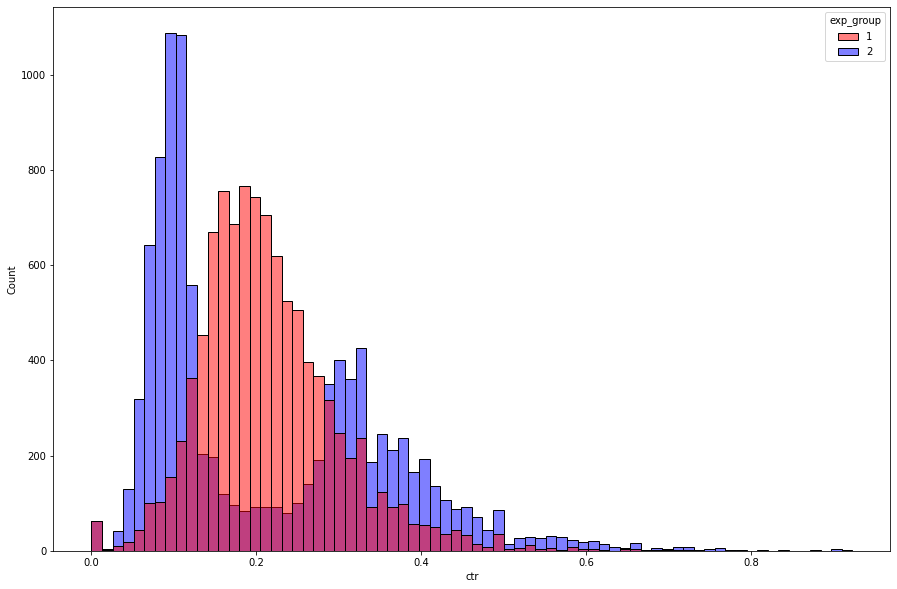

In [3]:
#Визуальная оценка
plt.figure(figsize=(15, 10))
sns.histplot(data=df,
            x='ctr',
            hue='exp_group',
            alpha=0.5,
            palette=['r', 'b'],
            kde=False)

Визуально различия между группами очевидны.

In [105]:
#t-test
stats.ttest_ind(df[df.exp_group == 2].ctr,
               df[df.exp_group == 1].ctr,
               equal_var=False)

Ttest_indResult(statistic=-0.7094392041270485, pvalue=0.4780623130874935)

In [106]:
#Тест Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 2].ctr,
               df[df.exp_group == 1].ctr,
               alternative='two-sided')

MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56)

Оба теста показывают значимые различия между группами.
Попробуем подвердить различия с помощью других методов.

In [107]:
#Функция для получения сглаженного CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [108]:
#Расчет группового CTR
global_ctr_1 = df[df.exp_group==1].likes.sum()/df[df.exp_group==1].views.sum()
global_ctr_2 = df[df.exp_group==2].likes.sum()/df[df.exp_group==2].views.sum()

<AxesSubplot:xlabel='ctr', ylabel='Count'>

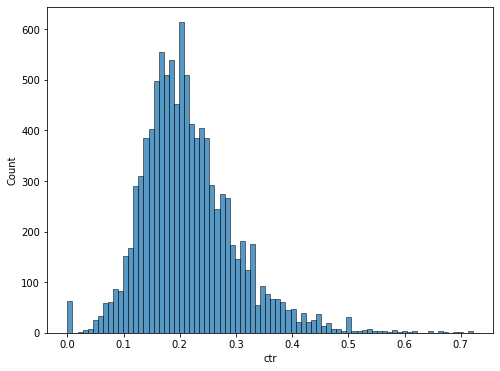

In [109]:
#Группа 1 - стандартный ctr
group_1 = df[df.exp_group==1].copy()
plt.figure(figsize=(8,6))
sns.histplot(data=group_1, x = 'ctr', )

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

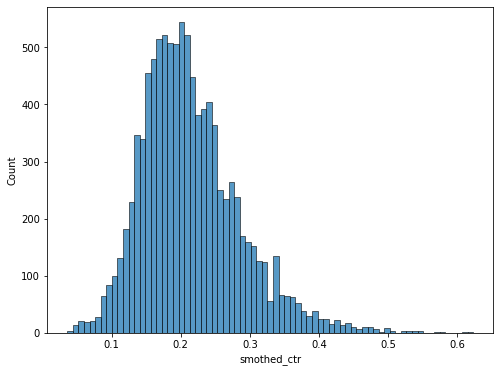

In [110]:
#Группа 1 - сглаженный ctr
group_1['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
plt.figure(figsize=(8, 6))
sns.histplot(group_1['smothed_ctr'])

<AxesSubplot:xlabel='ctr', ylabel='Count'>

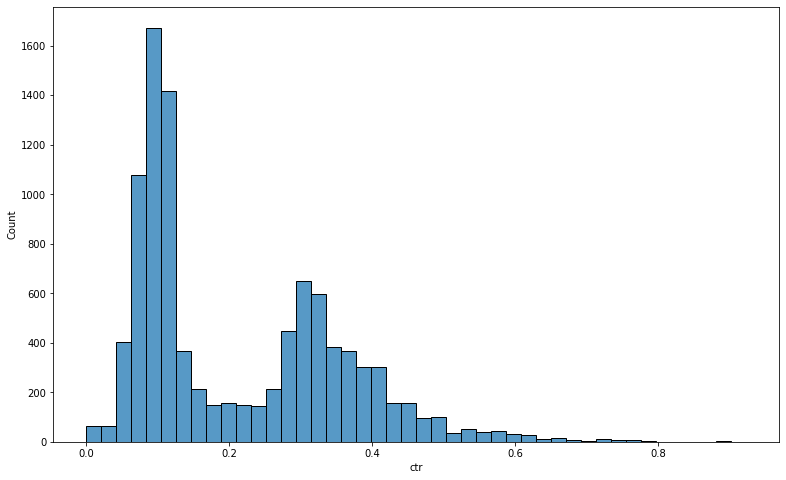

In [111]:
#Группа 2 - стандартный ctr
group_2 = df[df.exp_group==2].copy()
plt.figure(figsize=(13,8))
sns.histplot(data=group_2, x = 'ctr')

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

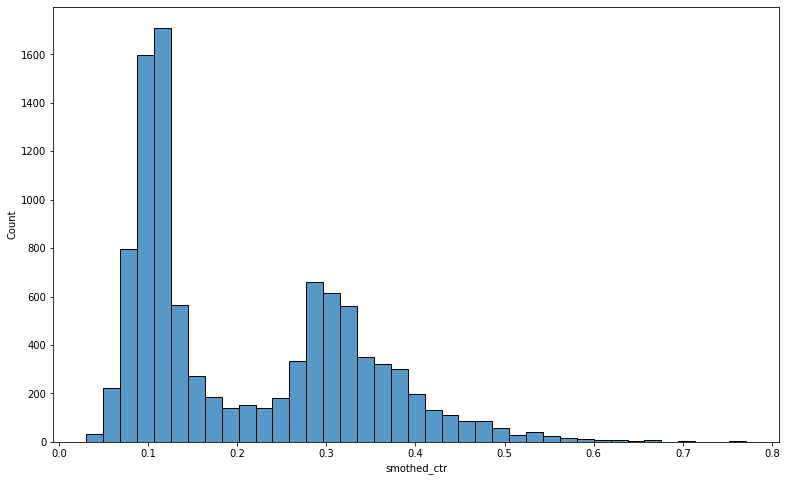

In [112]:
#Группа 2 - сглаженный ctr
group_2['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
plt.figure(figsize=(13,8))
sns.histplot(group_2['smothed_ctr'])

In [113]:
stats.ttest_ind(group_2['smothed_ctr'],
               group_1['smothed_ctr'],
               equal_var=False)

Ttest_indResult(statistic=-2.2841320431616983, pvalue=0.0223769815558559)

In [114]:
stats.mannwhitneyu(group_2['smothed_ctr'],
               group_1['smothed_ctr'],
               alternative='two-sided')

MannwhitneyuResult(statistic=43381083.0, pvalue=1.6163964114270227e-61)

Результат статистических тестов на сглаженных CTR показывает более значимое отличие между группамми.

In [115]:
#Функция для непараметрического бутстрепа.
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [116]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

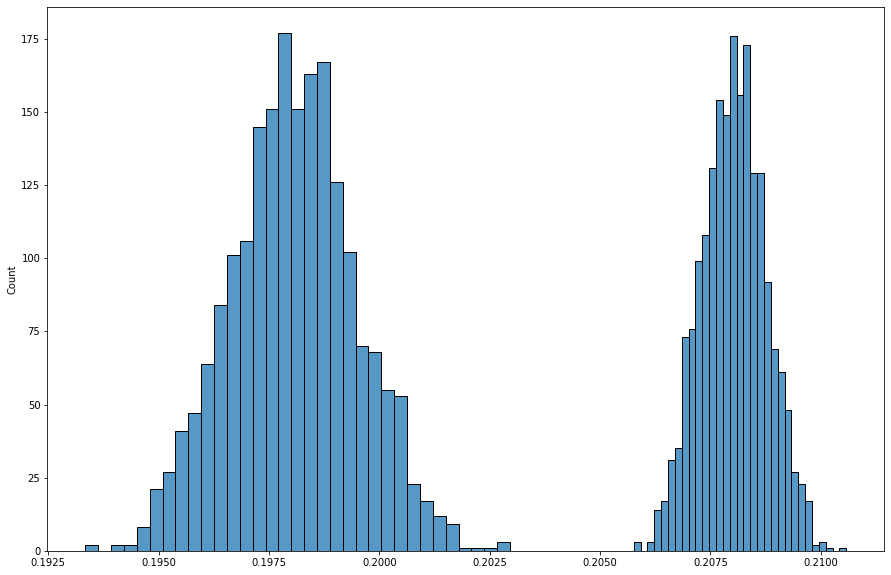

In [117]:
#Графики не пересекаются, различия очевидны. При проведении статистических тестов p-value будет равно 0.
plt.figure(figsize=(15,10))
sns.histplot(ctr1)
sns.histplot(ctr2)

<AxesSubplot:ylabel='Count'>

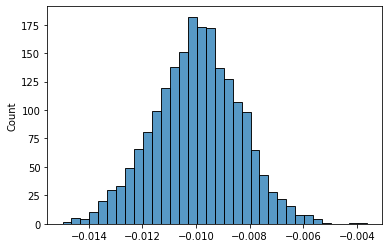

In [118]:
sns.histplot(ctr2 - ctr1)

Разница CTR групп не пересекает 0 и является отрицательной. Следовательно резульатат 2 группы хуже чем у контрольной.

In [119]:
#Бакетное преобразование.
q1 = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-01-31' and '2023-02-06' and exp_group in (2,1) 
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""
df1 = ph.read_clickhouse(q1, connection=connection) 

In [120]:
stats.ttest_ind(df1[df1['exp_group']==2].bucket_ctr,
               df1[df1['exp_group']==1].bucket_ctr,
               equal_var=False)

Ttest_indResult(statistic=-5.668234732053979, pvalue=3.4455951649945907e-07)

In [121]:
stats.mannwhitneyu(df1[df1['exp_group']==2].bucket_ctr,
               df1[df1['exp_group']==1].bucket_ctr,
               alternative='two-sided')

MannwhitneyuResult(statistic=505.0, pvalue=2.859963936492646e-07)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

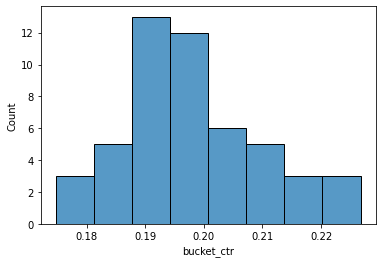

In [122]:
sns.histplot(df1[df1['exp_group']==2].bucket_ctr)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

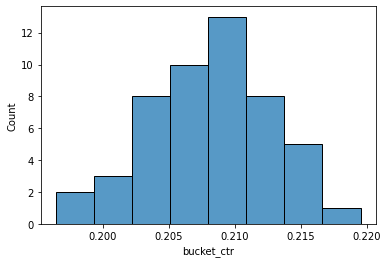

In [123]:
sns.histplot(df1[df1['exp_group']==1].bucket_ctr)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

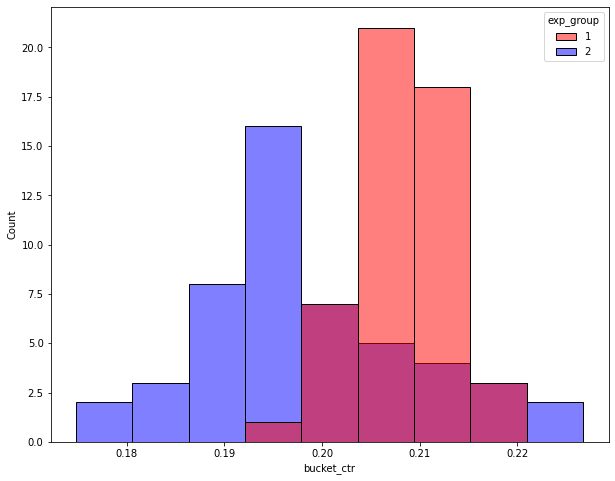

In [124]:
plt.figure(figsize=(10,8))
sns.histplot(data=df1, x = 'bucket_ctr', hue='exp_group', palette=['r', 'b'], alpha=0.5, kde=False)

Бакетное преобразование также демонстрирует статистически значимые различия между группами.

Вывод:
Из графика мы видим, что у большинства пользователей группы 2 низкий CTR (малое количество лайков по отношению к просмотрам). Одной из возможных причин может быть то, что после первых лайков наш алгоритм рекомендаций срабатывает неверно и все последующие посты, которые алгоритм показывает пользователю, ему не нравятся. 
Считаю, что использовать новый алгоритм нецелесообразно, так как в результате AB тестирования, мы  видим, что не добились поставленной цели по увеличению CTR. 